# Saliency Map 

There are the heatmaps that highlight pixels of the input image that most caused the output classification.

suppose we have a trained ConvNet for the problem of image classification. The ConvNet would produce some class scores and on the basis of the maximum score, we would get some output class for an input image.

# Saliency Map Extraction in PyTorch

Firstly, we need a pretrained ConvNet for image classification. Here, we'll be using the pretrained VGG-19 ConvNet from Pytorch torchvision module.

## VGG-19

A convolutional model network that has been trained on more than a million images from the ImageNet database. The network is 19 laers deep and classify images into 1000 object categories, such as the keybaord, mouse, pencil and many animals. 

# Import the Libraries

In [7]:
import torch 
import torchvision 
import torchvision.transforms as T 
import numpy as np 
import matplotlib.pyplot as plt 
from torchsummary import summary 

import requests 
from PIL import Image

# Call the model

In [8]:
model = torchvision.models.vgg19(pretrained=True)
model

/home/mike/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/mike/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [9]:
for param in model.parameters():
    param.requires_grad = False 

# Get the image

In [10]:
img = Image.open("./dataset/test.jpg")

# Preprocess the image

In [11]:
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])

    return transform(image)

# Function to deprocess imae 

 Y = (X - μ)/(σ) => Y ~ Distribution(0,1) if X ~ Distribution(μ,σ)
    => Y/(1/σ) follows Distribution(0,σ)
    => (Y/(1/σ) - (-μ))/1 is actually X and hence follows Distribution(μ,σ)

In [12]:
def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])

    return transform(image)

# Function to show an image

In [13]:
def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

Saliency map is the gradient of the maximum score value with respect to the input image. But note that the input image has 3 channels, R, G, B. To derive a single class saliency value for each pixel (i, j), we take the maximum magnitude across all color channels. 

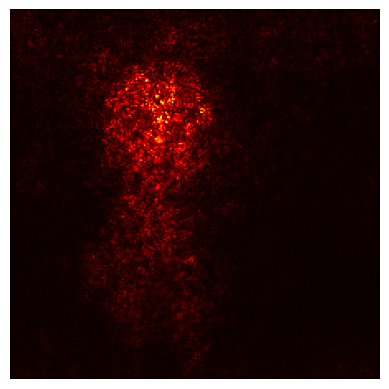

In [16]:
# preprocess the image 
X = preprocess(img)

# run the model in the evaluation model
model.eval()

# we need to find the gradient with respect to the input image,
# so we need to call requires_grad_on 
X.requires_grad_()

'''
forward pass through the model to get the scores, note the VGG-19 model
does not perform softmax at time and we also dont need softmax, 
we need scores, so that is perfect for us.
'''
scores = model(X)

# get the index corresponding to the maximum score and the 
# maximum score itself
score_max_index = scores.argmax()
score_max = scores[0, score_max_index]

'''
Backward function on score_max_performs the backward pass in the 
computation graph and calculate the score_max with respect to nodes 
in the computation graph
'''
score_max.backward()

'''
R, G, B. To derive a single class saliency value for each pixel (i, j),
we take the maximum magnitude across all colour channels
'''
saliency, _ = torch.max(X.grad.data.abs(), dim=1)

# code the plot the saliency map as a heatmap 
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis("off")
plt.show()